In [21]:
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as scint
import numpy as np
import time
import tqdm as tqdm
from custom_layer import ScaleAngles
import os
import glob

In [22]:
# replace the argparse / sys.argv code with a notebook-relative path
nb_dir = os.getcwd()   # notebook working directory (where the .ipynb is opened)
infile_0ps = glob.glob(os.path.join(nb_dir, "models0.1ns", "*.keras"))  # Load all .keras files in models0.0ns

In [23]:
indata  = np.load('500K22TO140dualfilm_0.1ns.npz', mmap_mode='r')
TIMES   = indata['TIMES']; HISTS = indata['HISTS']; ANGLES = indata['ANGLES']; LABELS = indata['LABELS']
nevents = TIMES.shape[0]

# Expand compressed datatypes to full precision for training
TIMES = TIMES.astype(np.float32)
HISTS = HISTS.astype(np.float32)
ANGLES = ANGLES.astype(np.float32)
LABELS = LABELS.astype(np.int32)

theta = np.arccos(ANGLES.T[6])*180/np.pi

MODEL INSPECTION

Output Layer: output
Output dtype: float32
Optimizer: <keras.src.optimizers.adam.Adam object at 0x12ef083b0>
[INFO] Evaluated 455040 events in 5.9604644775390625e-06 seconds;
1.3098770388403353e-05 µs per event

Predictions dtype: float32
Sample predictions (first 5):
[[0.13179131 0.8682087 ]
 [0.9660718  0.03392824]
 [0.13599834 0.8640017 ]
 [0.5969787  0.4030213 ]
 [0.9518371  0.04816287]]

Number of unique confidence values: 432166
Confidence range: [0.5000004768371582, 1.0]
Minimum step between unique values: 5.960464477539063e-08
Quantization bits (estimated): 24.0 bits


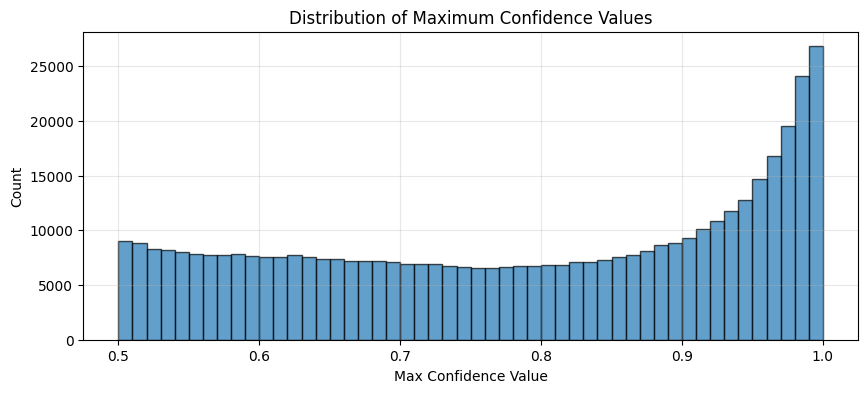


First 20 unique confidence values:
[0.5000005  0.5000045  0.50000584 0.5000059  0.500006   0.5000067
 0.5000105  0.50001127 0.50001144 0.50001484 0.5000172  0.50001925
 0.50002354 0.5000237  0.50003    0.50003386 0.50003666 0.5000367
 0.5000373  0.50004035]


Calculating accuracy for model 21: 100%|██████████| 100/100 [01:03<00:00,  1.59it/s]


In [ ]:
accuracies_list = []
efficiencies_list = []

for i, infile in enumerate(infile_0ps):
    model = keras.models.load_model(infile)
    
    predictions = model.predict((TIMES, HISTS, ANGLES), verbose=0)
    pred_labels = np.argmax(predictions, axis=1)
    
    if i == 0:
        # Model inspection
        print("=" * 60)
        print("MODEL INSPECTION")
        print("=" * 60)
        
        # Check output layer properties
        output_layer = model.layers[-1]
        print(f"\nOutput Layer: {output_layer.name}")
        print(f"Output dtype: {output_layer.dtype}")
        
        # Check for quantization in layer config
        if hasattr(model, 'optimizer'):
            print(f"Optimizer: {model.optimizer}")
        
        # Inspect prediction precision
        t1 = time.time()
        t2 = time.time()
        print(f'[INFO] Evaluated {nevents} events in {t2-t1} seconds;\n{((t2-t1)/nevents) * 10**6} µs per event')
        
        print(f"\nPredictions dtype: {predictions.dtype}")
        print(f"Sample predictions (first 5):\n{predictions[:5]}")
        
        # Check unique confidence values and their distribution
        max_confidences = np.max(predictions, axis=1)
        unique_confidences = np.unique(max_confidences)
        print(f"\nNumber of unique confidence values: {len(unique_confidences)}")
        print(f"Confidence range: [{float(max_confidences.min())}, {max_confidences.max()}]")
        
        # Compute the quantization step size
        if len(unique_confidences) > 1:
            sorted_unique = np.sort(unique_confidences)
            diffs = np.diff(sorted_unique)
            min_step = np.min(diffs[diffs > 0])
            print(f"Minimum step between unique values: {min_step}")
            print(f"Quantization bits (estimated): {-np.log2(min_step)} bits")
        
        # Show histogram of confidence values
        plt.figure(figsize=(10, 4))
        plt.hist(max_confidences, bins=50, edgecolor='black', alpha=0.7)
        plt.xlabel('Max Softmax Probability')
        plt.ylabel('Count')
        plt.xlim(0.5, 1.0)
        plt.title('Distribution of Maximum Softmax Probabilities')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # First 20 unique values
        print(f"\nFirst 20 unique confidence values:\n{sorted_unique[:20]}")
    
    confidences = 1 - np.linspace(0.5, 0.997, 100)
    accuracies = []
    efficiencies = []
    
    for confidence in tqdm.tqdm(confidences, total=len(confidences), desc=f'Calculating accuracy for model {i+1}'):
        correct = 0
        total = 0
        for j, pred in enumerate(predictions):
            if pred[np.argmax(pred)] >= 1 - confidence:
                total += 1
                if np.argmax(pred) == LABELS[j]:
                    correct += 1
        accuracies.append(correct/total if total else 0)
        efficiencies.append(total/len(predictions))
    
    efficiencies_list.append(efficiencies)
    accuracies_list.append(accuracies)

In [25]:
accuracies_array = np.array(accuracies_list)
mean_accuracies = np.mean(accuracies_array, axis=0)
std_accuracies = np.std(accuracies_array, axis=0)

efficiencies_array = np.array(efficiencies_list)
mean_efficiencies = np.mean(efficiencies_array, axis=0)
std_efficiencies = np.std(efficiencies_array, axis=0)

In [13]:
fX = np.array([
            0,
            0.015664074523400955,
            0.03132814904680191,
            0.046992223570202864,
            0.06265629809360382,
            0.07832037261700477,
            0.09398444714040571,
            0.10964852166380666,
            0.1253125961872076,
            0.14097667071060857,
            0.1566407452340095,
            0.17230481975741047,
            0.18796889428081143,
            0.2036329688042124,
            0.21929704332761335,
            0.23496111785101434,
            0.2506251923744153,
            0.26628926689781623,
            0.28195334142121725,
            0.2976174159446182,
            0.3132814904680191,
            0.3289455649914201,
            0.34460963951482104,
            0.360273714038222,
            0.37593778856162297,
            0.391601863085024,
            0.40726593760842494,
            0.4229300121318259,
            0.43859408665522687,
            0.45425816117862783,
            0.4699222357020288,
            0.48558631022542975,
            0.5012503847488308,
            0.5169144592722317,
            0.5325785337956327,
            0.5482426083190336,
            0.5639066828424346,
            0.5795707573658355,
            0.5952348318892365,
            0.6108989064126374,
            0.6265629809360383,
            0.6422270554594393,
            0.6578911299828402,
            0.6735552045062411,
            0.689219279029642,
            0.7048833535530429,
            0.7205474280764438,
            0.7362115025998447,
            0.7518755771232456,
            0.7675396516466465,
            0.7832037261700474,
            0.7988678006934482,
            0.8145318752168491,
            0.83019594974025,
            0.8458600242636509,
            0.8615240987870518,
            0.8771881733104527,
            0.8928522478338536,
            0.9085163223572545,
            0.9241803968806555,
            0.9398444714040564,
            0.9555085459274573,
            0.9711726204508582,
            0.9868366949742591,
            1.00250076949766,
            1.0181648440210609,
            1.0338289185444618,
            1.0494929930678627,
            1.0651570675912636,
            1.0808211421146645,
            1.0964852166380652,
            1.112149291161466,
            1.127813365684867,
            1.143477440208268,
            1.1591415147316688,
            1.1748055892550697,
            1.1904696637784706,
            1.2061337383018715,
            1.2217978128252724,
            1.2374618873486734,
            1.2531259618720743,
            1.2687900363954752,
            1.284454110918876,
            1.300118185442277,
            1.3157822599656779,
            1.3314463344890788,
            1.3471104090124797,
            1.3627744835358806,
            1.3784385580592815,
            1.3941026325826824,
            1.4097667071060833,
            1.4254307816294842,
            1.4410948561528851,
            1.456758930676286,
            1.472423005199687,
            1.4880870797230876,
            1.5037511542464885,
            1.5194152287698894,
            1.5350793032932903,
            1.5507433778166912,
            1.5664074523400922,
            1.582071526863493,
            1.597735601386894,
            1.6133996759102949,
            1.6290637504336958,
            1.6447278249570967,
            1.6603918994804976,
            1.6760559740038985,
            1.6917200485272994,
            1.7073841230507003,
            1.7230481975741012,
            1.7387122720975021,
            1.754376346620903,
            1.770040421144304,
            1.7857044956677048,
            1.8013685701911057,
            1.8170326447145067,
            1.8326967192379076,
            1.8483607937613085,
            1.8640248682847094,
            1.87968894280811,
            1.895353017331511,
            1.9110170918549119,
            1.9266811663783128,
            1.9423452409017137,
            1.9580093154251146,
            1.9736733899485155,
            1.9893374644719164,
            2.0050015389953173,
            2.020665613518718,
            2.036329688042119,
            2.05199376256552,
            2.067657837088921,
            2.083321911612322,
            2.0989859861357227,
            2.1146500606591236,
            2.1303141351825245,
            2.1459782097059255,
            2.1616422842293264,
            2.1773063587527273,
            2.192970433276128,
            2.208634507799529,
            2.22429858232293,
            2.239962656846331,
            2.255626731369732,
            2.2712908058931327,
            2.2869548804165336,
            2.3026189549399345,
            2.3182830294633354,
            2.3339471039867363,
            2.3496111785101372,
            2.365275253033538,
            2.380939327556939,
            2.39660340208034,
            2.412267476603741,
            2.4279315511271418,
            2.4435956256505427,
            2.459259700173943,
            2.474923774697344,
            2.490587849220745,
            2.506251923744146,
            2.5219159982675468,
            2.537580072790948,
            2.5532441473143495,
            2.5689082218377504,
            2.5845722963611517,
            2.6002363708845526,
            2.615900445407954,
            2.6315645199313553,
            2.6472285944547562,
            2.6628926689781576,
            2.6785567435015585,
            2.69422081802496,
            2.709884892548361,
            2.725548967071762,
            2.7412130415951634,
            2.756877116118565,
            2.7725411906419657,
            2.788205265165367,
            2.803869339688768,
            2.8195334142121693,
            2.8351974887355706,
            2.8508615632589716,
            2.866525637782373,
            2.882189712305774,
            2.897853786829175,
            2.9135178613525765,
            2.9291819358759774,
            2.9448460103993788,
            2.9605100849227797,
            2.976174159446181,
            2.9918382339695824,
            3.0075023084929833,
            3.0231663830163846,
            3.0388304575397855,
            3.054494532063187,
            3.0701586065865882,
            3.085822681109989,
            3.1014867556333905,
            3.1171508301567914,
            3.1328149046801927,
            3.148478979203594,
            3.164143053726995,
            3.1798071282503964,
            3.1954712027737973,
            3.2111352772971986,
            3.2267993518206,
            3.242463426344001,
            3.258127500867402,
            3.2737915753908036,
            3.2894556499142045,
            3.305119724437606,
            3.3207837989610067,
            3.336447873484408,
            3.3521119480078094,
            3.3677760225312103,
            3.3834400970546117,
            3.3991041715780126,
            3.414768246101414,
            3.4304323206248153,
            3.446096395148216,
            3.4617604696716175,
            3.4774245441950185,
            3.49308861871842,
            3.508752693241821,
            3.524416767765222,
            3.5400808422886234,
            3.5557449168120243,
            3.5714089913354257,
            3.587073065858827,
            3.602737140382228,
            3.6184012149056293,
            3.63406528942903,
            3.6497293639524315,
            3.665393438475833,
            3.681057512999234,
            3.696721587522635,
            3.7123856620460365,
            3.7280497365694374,
            3.7437138110928387,
            3.7593778856162396,
            3.775041960139641,
            3.7907060346630423,
            3.8063701091864433,
            3.8220341837098446,
            3.8376982582332455,
            3.853362332756647,
            3.869026407280048,
            3.884690481803449,
            3.9003545563268505,
            3.9160186308502514,
            3.9316827053736527,
            3.947346779897054,
            3.963010854420455,
            3.9786749289438563,
            3.9943390034672572,
            4.010003077990659,
            4.0256671525140595,
            4.041331227037461,
            4.056995301560862,
            4.072659376084263,
            4.088323450607665,
            4.103987525131066,
            4.119651599654467,
            4.135315674177868,
            4.150979748701269,
            4.16664382322467,
            4.182307897748071,
            4.197971972271473,
            4.213636046794874,
            4.229300121318275,
            4.244964195841677,
            4.2606282703650775,
            4.276292344888478,
            4.291956419411879,
            4.307620493935281,
            4.323284568458682,
            4.338948642982083,
            4.354612717505485,
            4.370276792028886,
            4.3859408665522865,
            4.401604941075688,
            4.417269015599089,
            4.43293309012249,
            4.448597164645892,
            4.464261239169293,
            4.479925313692694,
            4.495589388216095,
            4.5112534627394965,
            4.526917537262897,
            4.542581611786298,
            4.5582456863097,
            4.573909760833101,
            4.589573835356502,
            4.605237909879904,
            4.620901984403305,
            4.6365660589267055,
            4.652230133450106,
            4.667894207973508,
            4.683558282496909,
            4.69922235702031,
            4.714886431543712,
            4.730550506067113,
            4.746214580590514,
            4.761878655113915,
            4.777542729637316,
            4.793206804160717,
            4.808870878684118,
            4.82453495320752,
            4.840199027730921,
            4.855863102254322,
            4.8715271767777235,
            4.887191251301124,
            4.902855325824525,
            4.918519400347927,
            4.934183474871328,
            4.949847549394729,
            4.965511623918131,
            4.981175698441532,
            4.9968397729649325,
            5.012503847488333,
            5.028167922011735,
            5.043831996535136,
            5.059496071058537,
            5.075160145581939,
            5.09082422010534,
            5.106488294628741,
            5.1221523691521424,
            5.137816443675543,
            5.153480518198944,
            5.169144592722345,
            5.184808667245747,
            5.200472741769148,
            5.216136816292549,
            5.231800890815951,
            5.2474649653393515,
            5.263129039862752,
            5.278793114386154,
            5.294457188909555,
            5.310121263432956,
            5.325785337956357,
            5.341449412479759,
            5.35711348700316,
            5.3727775615265605,
            5.388441636049962,
            5.404105710573363,
            5.419769785096764,
            5.435433859620166,
            5.451097934143567,
            5.466762008666968,
            5.4824260831903695,
            5.49809015771377,
            5.513754232237171,
            5.529418306760572,
            5.545082381283974,
            5.560746455807375,
            5.576410530330776,
            5.592074604854178,
            5.6077386793775785,
            5.623402753900979,
            5.639066828424381,
            5.654730902947782,
            5.670394977471183,
            5.686059051994584,
            5.701723126517986,
            5.717387201041387,
            5.7330512755647876,
            5.748715350088189,
            5.76437942461159,
            5.780043499134991,
            5.795707573658393,
            5.811371648181794,
            5.827035722705195,
            5.842699797228597,
            5.8583638717519975,
            5.874027946275398,
            5.889692020798799,
            5.905356095322201,
            5.921020169845602,
            5.936684244369003,
            5.952348318892405,
            5.968012393415806,
            5.9836764679392065,
            5.999340542462608,
            6.015004616986009,
            6.03066869150941,
            6.046332766032811,
            6.061996840556213,
            6.077660915079614,
            6.093324989603015,
            6.108989064126416,
            6.124653138649817,
            6.140317213173218,
            6.15598128769662,
            6.171645362220021,
            6.187309436743422,
            6.202973511266823,
            6.2186375857902245,
            6.234301660313625,
            6.249965734837026,
            6.265629809360428,
            6.281293883883829,
            6.29695795840723,
            6.312622032930632,
            6.328286107454033,
            6.3439501819774335,
            6.359614256500835,
            6.375278331024236,
            6.390942405547637,
            6.406606480071038,
            6.42227055459444,
            6.437934629117841,
            6.453598703641242,
            6.4692627781646435,
            6.484926852688044,
            6.500590927211445,
            6.516255001734847,
            6.531919076258248,
            6.547583150781649,
            6.56324722530505,
            6.578911299828452,
            6.5945753743518525,
            6.610239448875253,
            6.625903523398655,
            6.641567597922056,
            6.657231672445457,
            6.672895746968859,
            6.68855982149226,
            6.704223896015661,
            6.7198879705390615,
            6.735552045062463,
            6.751216119585864,
            6.766880194109265,
            6.782544268632667,
            6.798208343156068,
            6.813872417679469,
            6.8295364922028705,
            6.845200566726271,
            6.860864641249672,
            6.876528715773074,
            6.892192790296475,
            6.907856864819876,
            6.923520939343277,
            6.939185013866679,
            6.9548490883900795,
            6.97051316291348,
            6.986177237436882,
            7.001841311960283,
            7.017505386483684,
            7.033169461007086,
            7.048833535530487,
            7.064497610053888,
            7.080161684577289,
            7.09582575910069,
            7.111489833624091,
            7.127153908147492,
            7.142817982670894,
            7.158482057194295,
            7.174146131717696,
            7.189810206241098,
            7.2054742807644985,
            7.221138355287899,
            7.2368024298113,
            7.252466504334702,
            7.268130578858103,
            7.283794653381504,
            7.299458727904906,
            7.315122802428307,
            7.3307868769517075,
            7.346450951475109,
            7.36211502599851,
            7.377779100521911,
            7.393443175045313,
            7.409107249568714,
            7.424771324092115,
            7.440435398615516,
            7.456099473138917,
            7.471763547662318,
            7.487427622185719,
            7.503091696709121,
            7.518755771232522,
            7.534419845755923,
            7.550083920279325,
            7.5657479948027255,
            7.581412069326126,
            7.597076143849527,
            7.612740218372929,
            7.62840429289633,
            7.644068367419731,
            7.659732441943133,
            7.675396516466534,
            7.6910605909899346,
            7.706724665513336,
            7.722388740036737,
            7.738052814560138,
            7.75371688908354,
            7.769380963606941,
            7.785045038130342,
            7.800709112653743,
            7.8163731871771445
        ])
fY = np.array([
            54.51238524164213,
            54.80933409220264,
            55.10628294276314,
            55.40323179332362,
            55.70018064388412,
            55.9971294944446,
            56.2940783450051,
            56.591027195565594,
            56.88797604612608,
            57.184924896686574,
            57.48187374724706,
            57.778822597807554,
            58.056469773081595,
            58.295513597782794,
            58.534557422483985,
            58.77360124718519,
            59.012645071886375,
            59.251688896587574,
            59.490732721288765,
            59.729776545989964,
            59.96882037069117,
            60.207864195392354,
            60.44690802009355,
            60.685951844794744,
            60.94578208903516,
            61.21600554304521,
            61.486228997055264,
            61.75645245106531,
            62.02667590507535,
            62.296899359085394,
            62.567122813095445,
            62.8373462671055,
            63.10756972111554,
            63.37779317512558,
            63.64801662913563,
            63.91824008314569,
            64.20182623543099,
            64.48541238771625,
            64.76899854000152,
            65.05258469228679,
            65.33617084457205,
            65.61975699685732,
            65.90334314914259,
            66.18692930142785,
            66.47051545371313,
            66.75410160599839,
            67.03768775828367,
            67.3108807007993,
            67.56328722377572,
            67.81569374675213,
            68.06810026972855,
            68.32050679270496,
            68.57291331568139,
            68.8253198386578,
            69.07772636163422,
            69.33013288461063,
            69.58253940758705,
            69.83494593056346,
            70.08735245353988,
            70.33085051099948,
            70.56989433570068,
            70.80893816040187,
            71.04798198510308,
            71.28702580980425,
            71.52606963450546,
            71.76511345920665,
            72.00415728390783,
            72.24320110860903,
            72.48224493331023,
            72.72128875801143,
            72.96033258271261,
            73.18601370913858,
            73.41169483556456,
            73.63737596199053,
            73.8630570884165,
            74.08873821484248,
            74.31441934126845,
            74.54010046769442,
            74.76578159412038,
            74.99146272054635,
            75.21714384697233,
            75.4428249733983,
            75.65316374254532,
            75.83281779713442,
            76.01247185172352,
            76.19212590631261,
            76.37177996090172,
            76.55143401549081,
            76.73108807007992,
            76.91074212466899,
            77.0903961792581,
            77.27005023384719,
            77.4497042884363,
            77.62935834302539,
            77.83078864665559,
            78.04310707480634,
            78.25542550295708,
            78.46774393110783,
            78.68006235925859,
            78.89238078740934,
            79.1046992155601,
            79.31701764371084,
            79.5293360718616,
            79.74165450001234,
            79.9539729281631,
            80.16629135631385,
            80.35485387641975,
            80.54341639652567,
            80.73197891663158,
            80.92054143673748,
            81.10910395684338,
            81.2976664769493,
            81.4862289970552,
            81.67479151716113,
            81.86335403726704,
            81.05191655737295,
            82.24047907747885,
            82.43448565984505,
            82.63938036673177,
            82.84427507361853,
            83.04916978050527,
            83.254064487392,
            83.45895919427873,
            83.66385390116547,
            83.86874860805221,
            84.07364331493895,
            84.2785380218257,
            84.48343272871242,
            84.68832743559918,
            84.85461879191305,
            85.00160847294048,
            85.14859815396792,
            85.29558783499537,
            85.44257751602282,
            85.58956719705026,
            85.73655687807769,
            85.88354655910516,
            86.03053624013259,
            86.17752592116003,
            86.32451560218747,
            86.47150528321491,
            86.62443394125357,
            86.77736259929222,
            86.93029125733088,
            87.08321991536953,
            87.23614857340817,
            87.38907723144683,
            87.5420058894855,
            87.69493454752414,
            87.84786320556279,
            88.00079186360145,
            88.15372052164008,
            88.30417460592409,
            88.44967954269872,
            88.59518447947335,
            88.740689416248,
            88.88619435302265,
            89.03169928979729,
            89.17720422657192,
            89.32270916334656,
            89.4682141001212,
            89.61371903689584,
            89.7592239736705,
            89.90472891044513,
            90.0462745292123,
            90.18584048897573,
            90.32540644873916,
            90.46497240850259,
            90.60453836826602,
            90.74410432802947,
            90.8836702877929,
            91.02323624755631,
            91.16280220731976,
            91.30236816708319,
            91.44193412684662,
            91.58150008661003,
            91.69285590557026,
            91.80421172453043,
            91.91556754349062,
            92.02692336245079,
            92.13827918141098,
            92.24963500037116,
            92.36099081933135,
            92.47234663829154,
            92.58370245725172,
            92.69505827621191,
            92.8064140951721,
            92.90292247160427,
            92.96973596298037,
            93.03654945435649,
            93.1033629457326,
            93.17017643710872,
            93.23698992848482,
            93.30380341986093,
            93.37061691123705,
            93.43743040261316,
            93.50424389398928,
            93.57105738536538,
            93.63787087674149,
            93.72448095815497,
            93.82098933458713,
            93.91749771101931,
            94.01400608745146,
            94.11051446388362,
            94.20702284031577,
            94.30353121674796,
            94.40003959318011,
            94.49654796961227,
            94.59305634604442,
            94.6895647224766,
            94.78607309890876,
            94.86327980005447,
            94.94048650120018,
            95.01769320234594,
            95.09489990349165,
            95.17210660463738,
            95.24931330578312,
            95.32652000692883,
            95.40372670807459,
            95.4809334092203,
            95.55814011036603,
            95.63534681151177,
            95.70760436514813,
            95.76996362376585,
            95.83232288238354,
            95.89468214100125,
            95.95704139961896,
            96.01940065823663,
            96.08175991685437,
            96.14411917547207,
            96.20647843408977,
            96.26883769270748,
            96.33119695132517,
            96.39355620994287,
            96.45393580955684,
            96.51332557966893,
            96.57271534978103,
            96.63210511989314,
            96.69149489000523,
            96.75088466011734,
            96.81027443022944,
            96.86966420034152,
            96.92905397045362,
            96.98844374056573,
            97.04783351067782,
            97.10722328078992,
            97.15918932963801,
            97.2111553784861,
            97.26312142733418,
            97.31508747618227,
            97.36705352503036,
            97.41901957387844,
            97.47098562272653,
            97.52295167157462,
            97.5749177204227,
            97.62688376927079,
            97.67884981811886,
            97.72240231620107,
            97.7491277127515,
            97.77585310930195,
            97.8025785058524,
            97.82930390240284,
            97.85602929895327,
            97.88275469550372,
            97.90948009205418,
            97.93620548860463,
            97.96293088515505,
            97.9896562817055,
            98.01638167825595,
            98.04508673381014,
            98.0747816188662,
            98.10447650392224,
            98.13417138897827,
            98.16386627403433,
            98.19356115909038,
            98.22325604414644,
            98.25295092920248,
            98.28264581425854,
            98.31234069931457,
            98.34203558437062,
            98.37173046942668,
            98.40439484298834,
            98.43705921654998,
            98.46972359011166,
            98.50238796367331,
            98.53505233723496,
            98.56771671079662,
            98.60038108435826,
            98.63304545791992,
            98.66570983148158,
            98.69837420504322,
            98.7310385786049,
            98.76073346366093,
            98.78448937170576,
            98.80824527975061,
            98.83200118779544,
            98.85575709584027,
            98.87951300388511,
            98.90326891192994,
            98.92702481997479,
            98.95078072801964,
            98.97453663606449,
            98.99829254410932,
            99.02204845215415,
            99.04283487169339,
            99.06213654697983,
            99.08143822226626,
            99.10073989755267,
            99.1200415728391,
            99.13934324812554,
            99.15864492341198,
            99.17794659869841,
            99.19724827398485,
            99.21654994927125,
            99.2358516245577,
            99.25515329984412,
            99.26554650961374,
            99.27593971938336,
            99.28633292915298,
            99.2967261389226,
            99.30711934869221,
            99.31751255846183,
            99.32790576823145,
            99.33829897800106,
            99.34869218777068,
            99.3590853975403,
            99.36947860730992,
            99.37888198757766,
            99.38630570884168,
            99.39372943010568,
            99.4011531513697,
            99.40857687263372,
            99.41600059389773,
            99.42342431516172,
            99.43084803642574,
            99.43827175768976,
            99.44569547895377,
            99.45311920021778,
            99.4605429214818,
            99.46598698374204,
            99.47044121650046,
            99.47489544925888,
            99.47934968201729,
            99.4838039147757,
            99.4882581475341,
            99.4927123802925,
            99.49716661305092,
            99.50162084580931,
            99.50607507856772,
            99.51052931132614,
            99.51498354408457,
            99.52834624235977,
            99.541708940635,
            99.55507163891023,
            99.56843433718545,
            99.58179703546068,
            99.59515973373588,
            99.6085224320111,
            99.62188513028634,
            99.63524782856156,
            99.64861052683679,
            99.661973225112,
            99.6723664348816,
            99.67682066764002,
            99.6812749003984,
            99.68572913315683,
            99.69018336591523,
            99.69463759867365,
            99.69909183143206,
            99.70354606419045,
            99.70800029694887,
            99.71245452970726,
            99.71690876246566,
            99.72136299522408,
            99.72482739848063,
            99.72779688698623,
            99.73076637549183,
            99.73373586399745,
            99.73670535250304,
            99.73967484100865,
            99.74264432951425,
            99.74561381801986,
            99.74858330652546,
            99.75155279503106,
            99.75452228353666,
            99.75749177204227,
            99.75897651629508,
            99.76046126054787,
            99.76194600480068,
            99.76343074905348,
            99.76491549330628,
            99.7664002375591,
            99.76788498181189,
            99.7693697260647,
            99.7708544703175,
            99.7723392145703,
            99.77382395882309,
            99.77728836207967,
            99.78471208334368,
            99.79213580460768,
            99.79955952587169,
            99.8069832471357,
            99.81440696839972,
            99.82183068966374,
            99.82925441092775,
            99.83667813219176,
            99.84410185345577,
            99.85152557471977,
            99.85894929598379,
            99.86439335824406,
            99.86884759100248,
            99.87330182376087,
            99.87775605651927,
            99.8822102892777,
            99.88666452203609,
            99.8911187547945,
            99.89557298755291,
            99.90002722031133,
            99.90448145306974,
            99.90893568582813,
            99.91338991858652,
            99.91487466283934,
            99.91635940709213,
            99.91784415134494,
            99.91932889559774,
            99.92081363985054,
            99.92229838410336,
            99.92378312835613,
            99.92526787260896,
            99.92675261686176,
            99.92823736111455,
            99.92972210536735,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93071193486922,
            99.93269159387296,
            99.93566108237857,
            99.93863057088417,
            99.9416000593898,
            99.94456954789537,
            99.947539036401,
            99.9505085249066,
            99.9534780134122,
            99.95644750191781,
            99.9594169904234,
            99.962386478929,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.9653559674346,
            99.96585088218555,
            99.96733562643836,
            99.96882037069116,
            99.97030511494395,
            99.97178985919675,
            99.97327460344957,
            99.97475934770237,
            99.97624409195517,
            99.97772883620797,
            99.97921358046077,
            99.98069832471357,
            99.98218306896639,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731,
            99.98267798371731
    ])

sep_to_acc = scint.interp1d(fX, fY/100, kind="linear", bounds_error=False, fill_value="extrapolate")
acc_to_sep = scint.interp1d(fY/100, fX, kind="linear", bounds_error=False, fill_value="extrapolate")

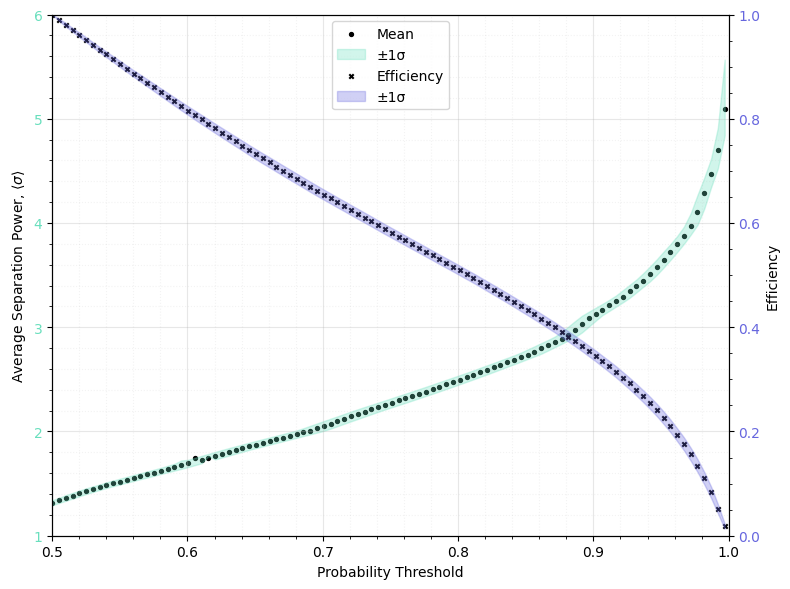

In [45]:
import matplotlib.ticker as ticker

mis_id = 1 - np.array(mean_accuracies)

fig, ax1 = plt.subplots(figsize=(8, 6))

# ----- LEFT Y-AXIS: Sep Power -----
colour_sep = "#69DFBD"

ax1.scatter(1 - confidences, acc_to_sep(mean_accuracies), marker='o', c='k', label='Mean', s=8)
ax1.fill_between(1 - confidences, acc_to_sep(mean_accuracies - std_accuracies), acc_to_sep(mean_accuracies + std_accuracies), alpha=0.3, color=colour_sep, label='±1σ')
ax1.set_xlabel('Probability Threshold')
ax1.set_ylabel(r'Average Separation Power, $\langle\sigma\rangle$')
ax1.tick_params(axis='y', labelcolor=colour_sep)
ax1.set_ylim(1, 6)
ax1.set_xlim(0.5, 1)

ax1.minorticks_on()
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.grid(which='major', linestyle='-', alpha=0.3)
ax1.grid(which='minor', linestyle=':', alpha=0.15)

# ----- RIGHT Y-AXIS: Event Efficiency -----
ax2 = ax1.twinx()

colour_eff = "#6666DE"

ax2.scatter(1 - confidences, efficiencies, color='k', marker='x', label='Efficiency', s=10)
ax2.fill_between(1 - confidences, efficiencies - std_efficiencies, efficiencies + std_efficiencies, alpha=0.3, color=colour_eff, label='±1σ')
ax2.set_ylabel('Efficiency')
ax2.tick_params(axis='y', labelcolor=colour_eff)
ax2.set_ylim(0, 1)

ax2.minorticks_on()
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.tight_layout()
plt.show()